In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.ContParticleFilter import PFHestonContinuous
from src.Heston import *
from scipy.optimize import minimize
# from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.5
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] - params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 0, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

0.15


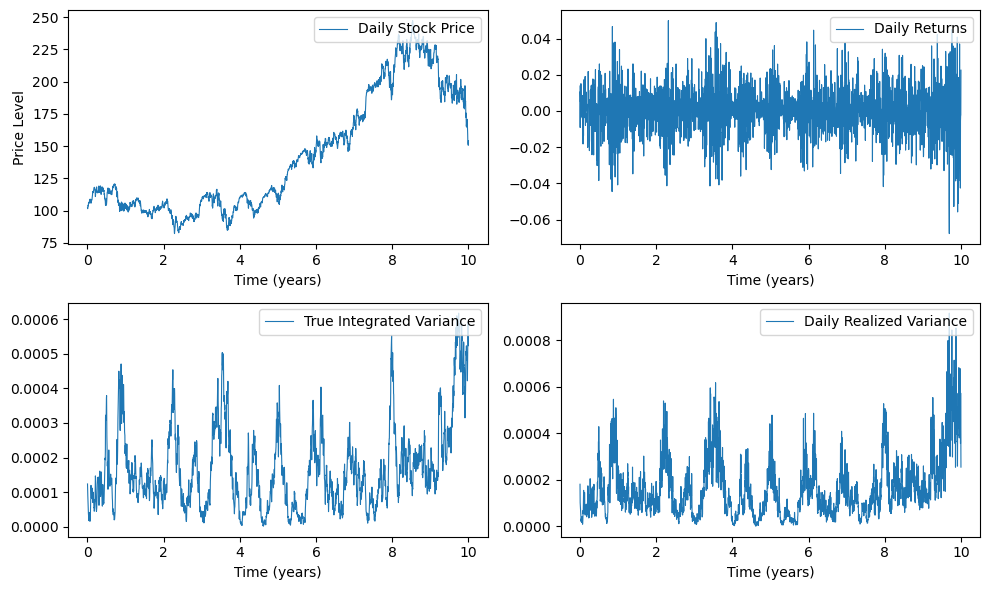

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = 6 * 252 

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [6]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001])

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.009492
theta: 0.000119
xi: 0.001427
mu: 0.000448
sigma: 0.000100
Negative Log-Likelihood: -14129.033022
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [0.00949199 0.00011901 0.00142672 0.00044837 0.00010046]


### Both - Corr

In [7]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])

fit_results_both = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both_corr = hkf_both_corr.filter(params_opt_both)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
V_filt_both_test_corr = hkf_both_test_corr.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']

C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.011003
theta: 0.000104
xi: 0.001349
mu: 0.000260
sigma: 0.000001
rho: -0.187829
Negative Log-Likelihood: -14147.842376
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 1.10029510e-02  1.04170124e-04  1.34889567e-03  2.60252627e-04
  1.00000000e-06 -1.87828578e-01]


### Return

In [8]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.019727
theta: 0.000192
xi: 0.007934
mu: -0.000985
Negative Log-Likelihood: -3868.750121
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 0.01972684  0.00019184  0.00793372 -0.00098545]


### Return - Corr

In [9]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
V_filt_returns_test_corr = hkf_returns_test_corr.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.019551
theta: 0.000193
xi: 0.007927
mu: -0.000957
rho: -0.000058
Negative Log-Likelihood: -3868.750575
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 1.95506889e-02  1.92580924e-04  7.92654349e-03 -9.56780169e-04
 -5.79744140e-05]


### RV

In [10]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
V_filt_rv_test = hkf_rv_test.filter(params=params_opt_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.007569
theta: 0.000132
xi: 0.001934
sigma: 0.002746
Negative Log-Likelihood: -11000.599258
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.00756935 0.00013157 0.00193393 0.00274617]


### PF

In [11]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.2, 0.2),    # mu
    (1, 10),        # kappa
    (0.02, 0.1),    # theta
    (0.05, 0.8),    # xi
    (-1, 0),        # rho
    V0              # v0
]

V_pf_train, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
V_pf_train_daily = V_pf_train / 252

resampling since: 929.4091724712688
resampling since: 1570.2270666931136
resampling since: 1050.4528781105644
resampling since: 111.17153509905701
resampling since: 599.2471988881059
resampling since: 2312.874600037447
resampling since: 3319.4255429935447
resampling since: 2464.2047361107766
resampling since: 2659.4800853462334
resampling since: 2536.5100918263993
resampling since: 630.6162209398852
resampling since: 3174.0200698538474
resampling since: 1789.6641688495445
resampling since: 582.0387608766297
resampling since: 1713.1566891441155
resampling since: 341.9447168931854
resampling since: 2873.218852708385
resampling since: 3175.4122515173785
resampling since: 900.9993655394361
resampling since: 1728.0331826100157
resampling since: 3055.4033096191433
resampling since: 1938.5450882738162
resampling since: 1837.331751971003
resampling since: 2641.815980461782
resampling since: 1621.563522912876
resampling since: 2627.876010264217
resampling since: 2472.4837746467892
resampling si

In [12]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

param_bounds_test = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))
param_bounds_test.append(V_pf_train[-1])

V_pf_test, _ = pf_heston_test.filter(param_bounds_test, predict_obs=False)
V_pf_test_daily = V_pf_test / 252

resampling since: 3164.202221556712
resampling since: 3438.106932561852
resampling since: 2978.8637966853303
resampling since: 2412.483097454147
resampling since: 3285.527683267157
resampling since: 1100.3099125466335
resampling since: 3419.1063856132346
resampling since: 3498.9655396728626
resampling since: 3248.2060279692623
resampling since: 3449.7938648892978
resampling since: 3368.7978729075508
resampling since: 3489.2130659107906
resampling since: 3273.318318069037
resampling since: 2267.534254078476
resampling since: 3349.1106990307508
resampling since: 2639.2016065067073
resampling since: 3347.31442866153
resampling since: 3417.1519640742476
resampling since: 3312.3919762778914
resampling since: 2591.5710688426866
resampling since: 3281.384530510869
resampling since: 3350.870991028988
resampling since: 1781.305733306298
resampling since: 3497.4420759149007
resampling since: 3372.1326884238847
resampling since: 2931.071725294756
resampling since: 2244.0438887141436
resampling si

## Plot

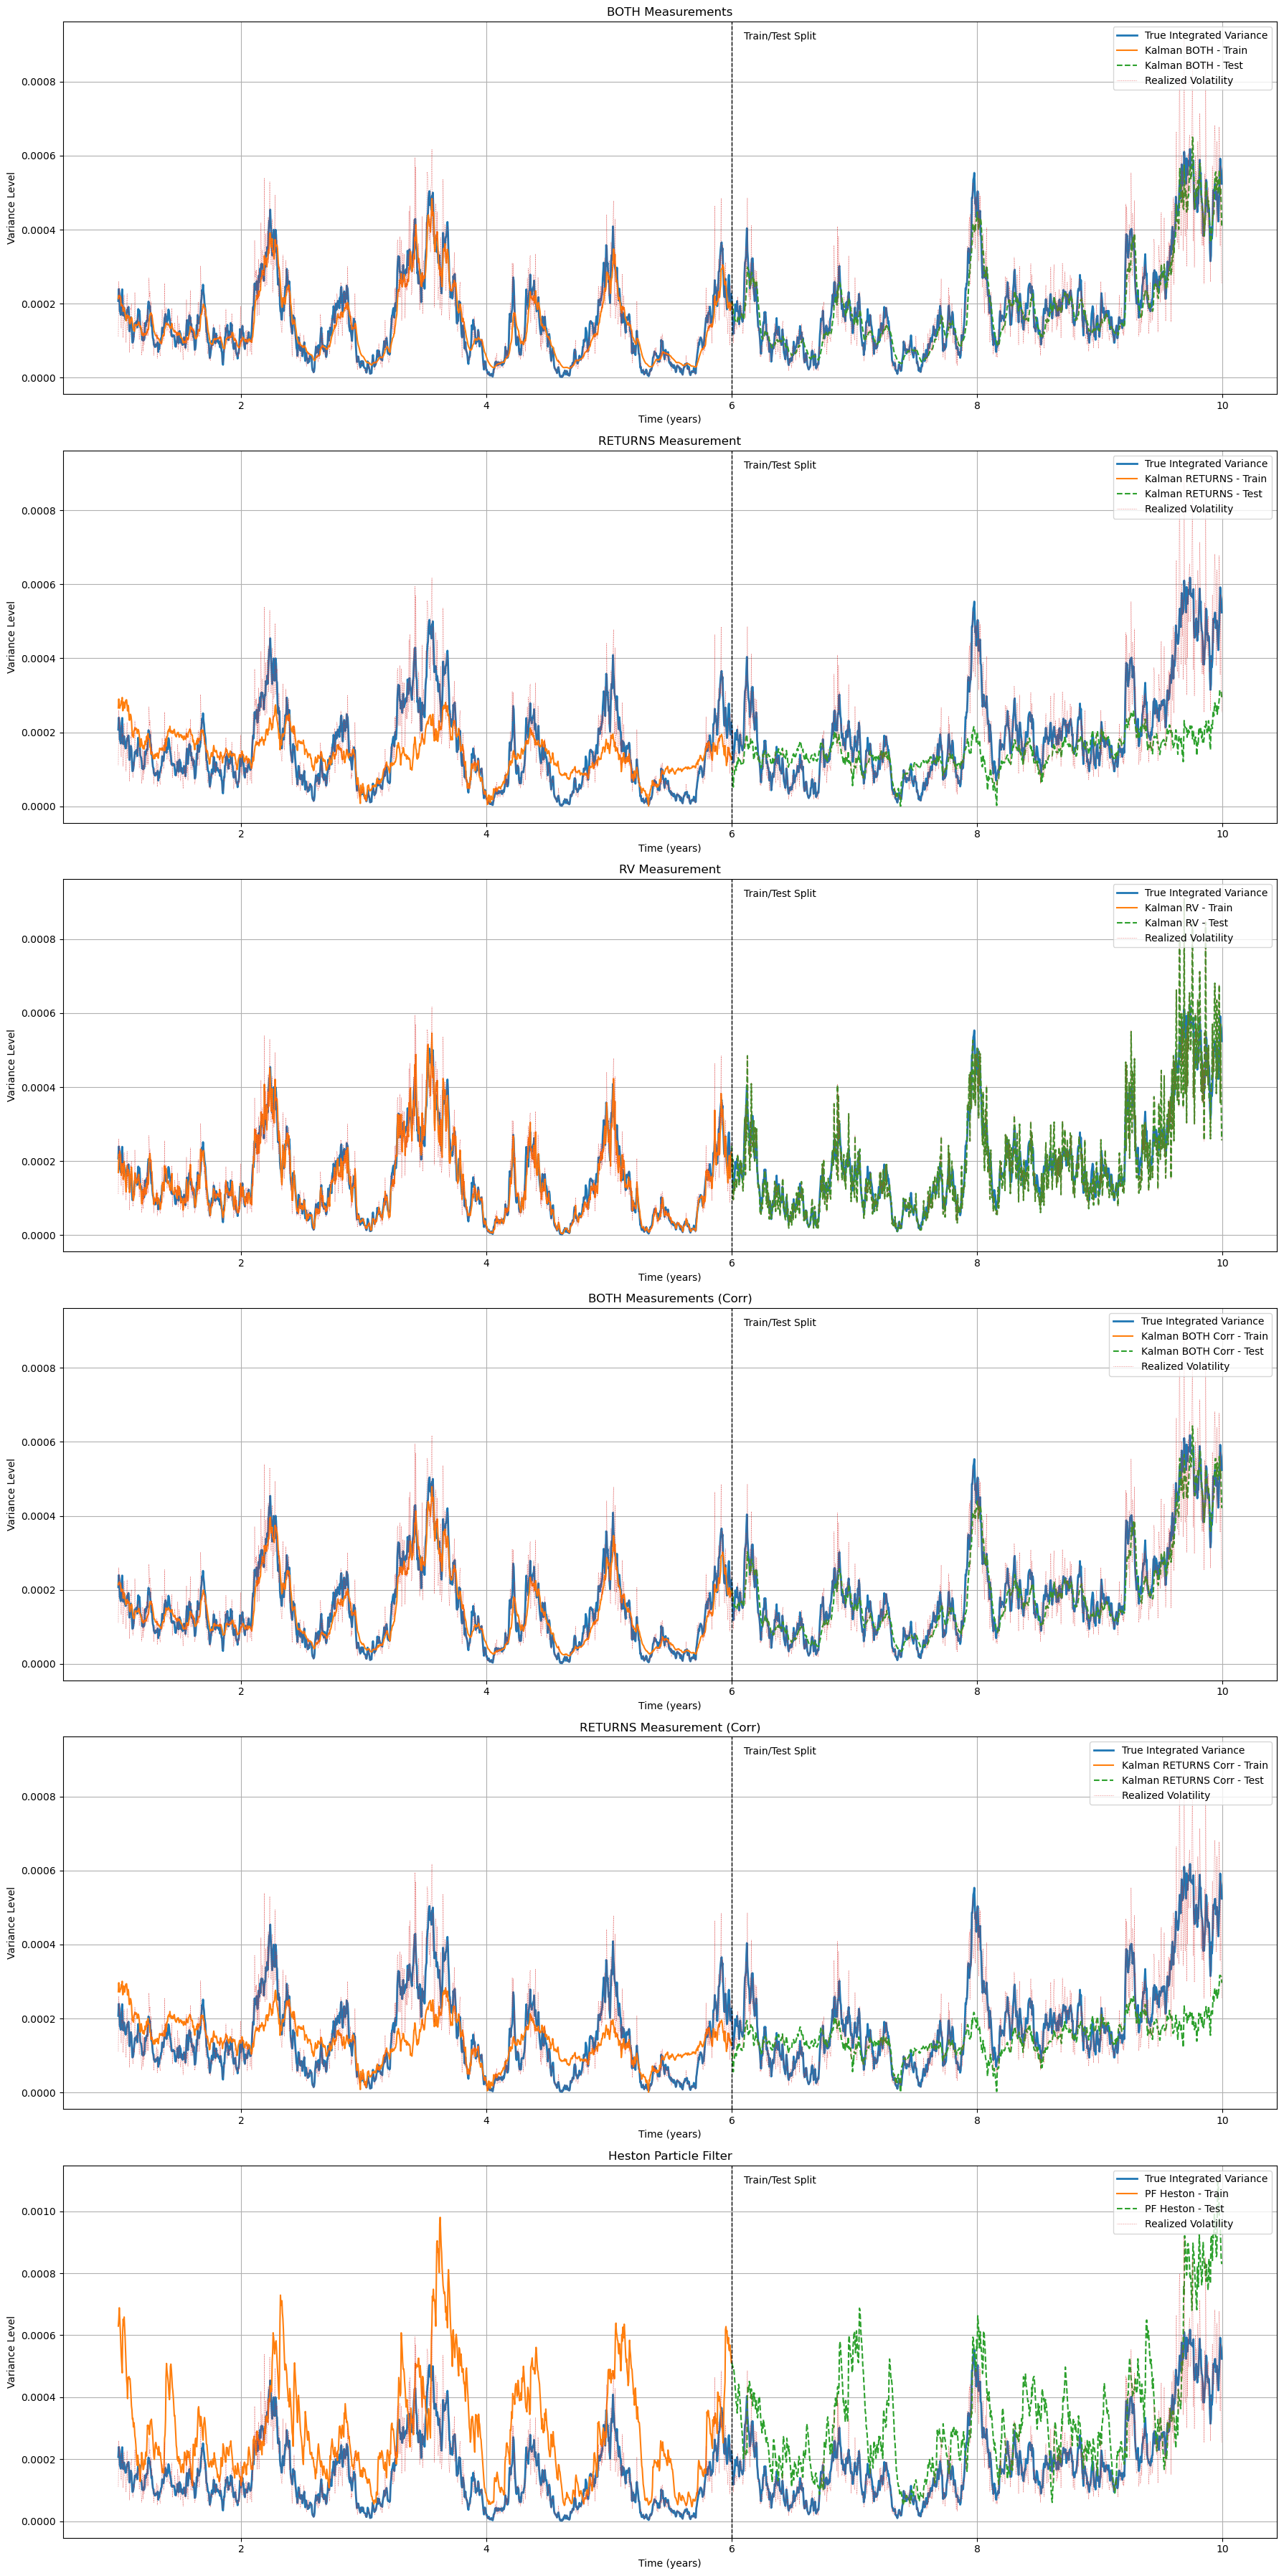

In [14]:
titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "BOTH Measurements (Corr)", "RETURNS Measurement (Corr)", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both['V_filt'], train_result_returns['V_filt'], train_result_rv['V_filt'], train_result_both_corr['V_filt'], train_result_returns_corr['V_filt'], V_pf_train_daily]
test_all = [V_filt_both_test, V_filt_returns_test, V_filt_rv_test, V_filt_both_test_corr, V_filt_returns_test_corr, V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252,
    save_path=r"C:\Users\688228hh\Kalman-Heston-Filter\output\base.png"
)

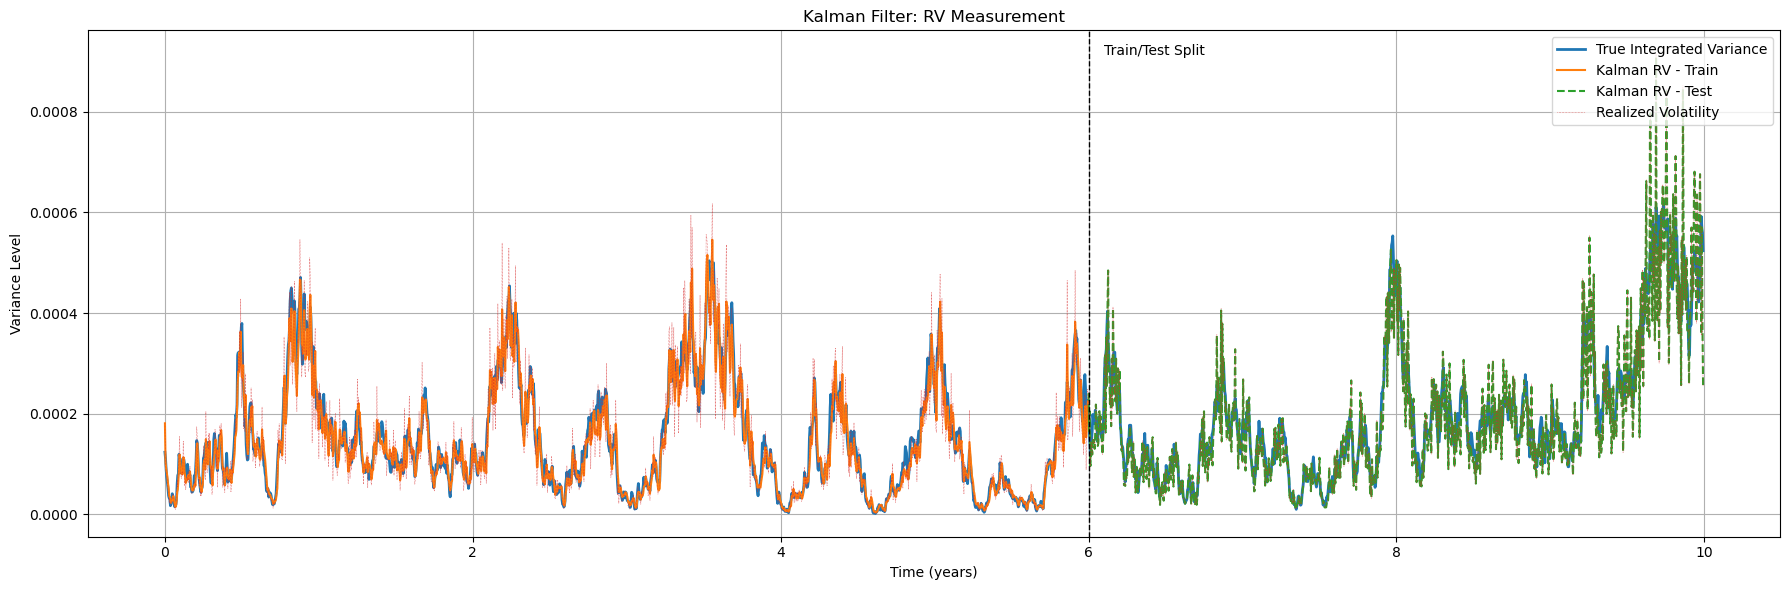

In-Sample RMSE (RV Measurement): 0.000026
Out-of-Sample RMSE (RV Measurement): 0.000055


(2.5867919148173176e-05, 5.4892072600495645e-05)

In [14]:
Utility.plot_filter_result(
    plot_index=2,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)

In [68]:
# Print RMSEs
for k, v in rmse_is_dict.items():
    print(f"In-Sample RMSE ({k}): {v:.6f}")

In-Sample RMSE (BOTH Measurements): 0.000026
In-Sample RMSE (RETURNS Measurement): 0.000043
In-Sample RMSE (RV Measurement): 0.000019


In [69]:
# Print RMSEs
for k, v in rmse_oos_dict.items():
    print(f"Out-of-Sample RMSE ({k}): {v:.6f}")

Out-of-Sample RMSE (BOTH Measurements): 0.000024
Out-of-Sample RMSE (RETURNS Measurement): 0.000107
Out-of-Sample RMSE (RV Measurement): 0.000034
